/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


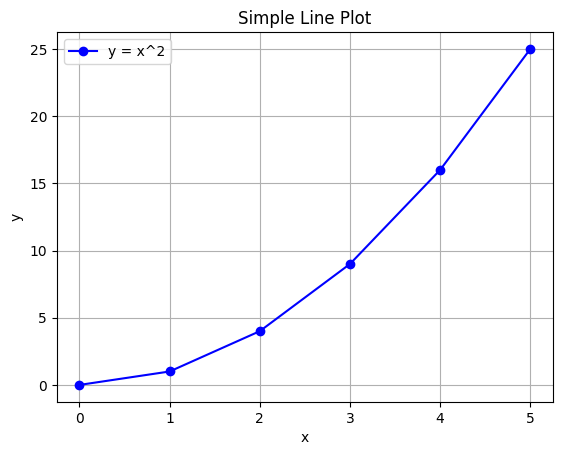

cuda


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import sys
import re
import argparse
import numpy as np

import sys



import matplotlib.pyplot as plt



# Data for the line
x = [0, 1, 2, 3, 4, 5]
y = [0, 1, 4, 9, 16, 25]

# Plotting the line
plt.plot(x, y, label='y = x^2', color='blue', marker='o')
plt.title('Simple Line Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [2]:
'''Train MNIST with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import sys
import re
import argparse
import numpy as np

import matplotlib.pyplot as plt

import sys

# Define the neural network model
class simple_FC(nn.Module):
    def __init__(self, n_hidden, input_dim, n_classes):
        super(simple_FC, self).__init__()
        self.features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, n_hidden),
            nn.ReLU()
        )
        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        return out
        
def filter_classes(dataset, classes):
    indices = [i for i, target in enumerate(dataset.targets) if target in classes]
    dataset.targets = dataset.targets[indices]
    dataset.data = dataset.data[indices]
    return dataset


def parse_args():
    # Remove Jupyter kernel arguments from sys.argv
    sys.argv = [arg for arg in sys.argv if not arg.endswith('.json')]

    # Create a parser
    parser = argparse.ArgumentParser()

    # Add your expected arguments
    parser.add_argument('--verbose', action='store_true', help='Increase output verbosity')
    parser.add_argument('--data_path', type=str, help='Path to the data')
    parser.add_argument('--ckpt_path', type=str, help='Path to the checkpoint')
    parser.add_argument('--log_path', type=str, help='Path to the log')

    # Parse known arguments
    known_args, unknown_args = parser.parse_known_args()

    return known_args

# Parse arguments
args = parse_args()

def train(epoch, net):
    if args.verbose:
        print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        targets = torch.nn.functional.one_hot(targets, num_classes=10).float()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets.argmax(1)).sum().item()
        if args.verbose:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return 100.*correct/total, train_loss/(batch_idx+1)


def test(epoch, net, model_name, save_checkpoint=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            targets = torch.nn.functional.one_hot(targets, num_classes=10).float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.argmax(1)).sum().item()
            if args.verbose:
                progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    acc = 100.*correct/total
    if save_checkpoint:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, os.path.join(args.ckpt_path, '%s.pth'%model_name))
        best_acc = acc
    return 100.*correct/total, test_loss/(batch_idx+1)


parser = argparse.ArgumentParser(description='PyTorch MNIST Double Descent Curve')
parser.add_argument('--verbose', default=0, type=int, help='level of verbos')
parser.add_argument('--reuse', action='store_true', help='parameter reuse')
parser.add_argument('--data_path', default='./data', type=str, help='data directory')
parser.add_argument('--ckpt_path', default='./ckpt', type=str, help='checkpoint directory')
parser.add_argument('--log_path', default='./log', type=str, help='log directory')
args, _ = parser.parse_known_args()

if not os.path.isdir(args.data_path):
    os.mkdir(args.data_path)
if not os.path.isdir(args.ckpt_path):
    os.mkdir(args.ckpt_path)
if not os.path.isdir(args.log_path):
    os.mkdir(args.log_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Update the dataset-specific parts without data augmentation and in grayscale
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize grayscale images
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Normalize grayscale images
])

# Load and filter training dataset
trainset = torchvision.datasets.SVHN(
    root=args.data_path, split='train', download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

# Load and filter testing dataset
testset = torchvision.datasets.SVHN(
    root=args.data_path, split='test', download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# Update input dimension for grayscale SVHN
input_dim = 32 * 32  # Since images are now grayscale

# Update the number of classes for SVHN
n_classes = 10



n_hidden_units = [1, 3, 5, 7, 9, 10, 20, 30, 32, 34, 35, 37, 38, 40, 45, 50, 60, 70, 80, 90, 100, 110, 130, 150, 170, 200, 250]
n_epoch = 1200

for n_hidden_unit in n_hidden_units:
    # Model
    net = simple_FC(n_hidden_unit,input_dim,n_classes)
    print('Number of parameters: %d'%sum(p.numel() for p in net.parameters()))
    net = net.cuda()
    net = net.to(device)
    if device == 'cuda':
        net = net.cuda()
        cudnn.benchmark = True
    ### initialization
    if n_hidden_unit == 1: # smallest network
        torch.nn.init.xavier_uniform_(net.features[1].weight, gain=1.0)
        torch.nn.init.xavier_uniform_(net.classifier.weight, gain=1.0)
    elif n_hidden_unit > 38: # interpolation point: Number of data (4000) * number of class (10) = number of parameters (38*1024 + 38 + 38*10 + 10)
        torch.nn.init.normal_(net.features[1].weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(net.classifier.weight, mean=0.0, std=0.1)
    else: 
        torch.nn.init.normal_(net.features[1].weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(net.classifier.weight, mean=0.0, std=0.1)
        if True:
            print('use previous checkpoints to initialize the weights')
            i = 1 # load the closest previous model for weight reuse
            while not os.path.exists(os.path.join(args.ckpt_path, 'simple_FC_%d.pth'%(n_hidden_unit-i))):
                print('loading from simple_FC_%d.pth'%(n_hidden_unit-i))
                i += 1
            checkpoint = torch.load(os.path.join(args.ckpt_path, 'simple_FC_%d.pth'%(n_hidden_unit-i)))
            with torch.no_grad():
                net.features[1].weight[:n_hidden_unit-i, :].copy_(checkpoint['net']['features.1.weight'])
                net.features[1].bias[:n_hidden_unit-i].copy_(checkpoint['net']['features.1.bias'])
                net.classifier.weight[:, :n_hidden_unit-i].copy_(checkpoint['net']['classifier.weight'])
                net.classifier.bias.copy_(checkpoint['net']['classifier.bias'])
    ### training and testing
    best_acc = 0
    start_epoch = 0
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.95)
    for epoch in range(start_epoch, start_epoch+n_epoch):
        if (epoch+1) % 100 == 0:
            if n_hidden_unit <= 38: # learning rate schedule
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.9
        train_acc, train_loss = train(epoch, net)
        if n_hidden_unit <= 38 and train_acc == 1 or epoch == start_epoch+n_epoch-1: # early stop before interpolation
            test_acc, test_loss = test(epoch, net, 'simple_FC_%d'%(n_hidden_unit), save_checkpoint=True)
            print('classification error reaches 0, stop training')
            break
    print('Training Loss: %.3f | Acc: %.3f%%' % (train_loss, train_acc))
    print('Test Loss: %.3f | Acc: %.3f%%\n' % (test_loss, test_acc))
    with open(os.path.join(args.log_path, 'FC_%d.txt'%n_hidden_unit), 'w') as fw:
        fw.write('Number of parameters: %d\n'%sum(p.numel() for p in net.parameters()))
        fw.write('Training Loss: %.3f | Acc: %.3f%%\n' % (train_loss, train_acc))
        fw.write('Test Loss: %.3f | Acc: %.3f%%\n' % (test_loss, test_acc))



model_names = sorted([int(fn.split('_')[1].split('.')[0]) for fn in os.listdir(args.log_path)])

train_losses = {model_name:0. for model_name in model_names}
test_losses = {model_name:0. for model_name in model_names}
train_accs = {model_name:0. for model_name in model_names}
test_accs = {model_name:0. for model_name in model_names}
n_params = {model_name:0. for model_name in model_names}

for model_name in model_names:
    with open(os.path.join('log', 'FC_%d.txt'%(model_name))) as f:
        for line in f:
            if line.startswith('Number'):
                n_params[model_name] = float(line.rstrip().split()[-1])
            if line.startswith('Training'):
                loss = re.search(r'Loss: (.*?) \|', line).group(1)
                train_losses[model_name] = float(loss)
                acc = re.search(r'Acc: (.*?)\%', line).group(1)
                train_accs[model_name] = float(acc)
            if line.startswith('Test'):
                loss = re.search(r'Loss: (.*?) \|', line).group(1)
                test_losses[model_name] = float(loss)
                acc = re.search(r'Acc: (.*?)\%', line).group(1)
                test_accs[model_name] = float(acc)


# plot 
plt.clf()
fig = plt.figure()
ax = plt.subplot(111)
plt.plot([n_params[model_name] for model_name in model_names], [train_losses[model_name] for model_name in model_names], marker='o', label='train', color='#e31a1c')
plt.plot([n_params[model_name] for model_name in model_names], [test_losses[model_name] for model_name in model_names], marker='o', label='test', color='#1f78b4')
plt.ylabel('loss')
box = ax.get_position()
plt.tight_layout()
ax.set_position([box.x0, box.y0,
             box.width, box.height * 0.9])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, ncol=4)

plt.savefig('MNIST_double_descent_loss.png')


plt.clf()
fig = plt.figure()
ax = plt.subplot(111)
plt.plot([n_params[model_name] for model_name in model_names], [train_accs[model_name] for model_name in model_names], marker='o', label='train', color='#e31a1c')
plt.plot([n_params[model_name] for model_name in model_names], [test_accs[model_name] for model_name in model_names], marker='o', label='test', color='#1f78b4')
plt.ylabel('accuracy')
box = ax.get_position()
plt.tight_layout()
ax.set_position([box.x0, box.y0,
             box.width, box.height * 0.9])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, ncol=4)

plt.savefig('MNIST_double_descent_accuracy.png')


100%|██████████| 182040794/182040794 [00:53<00:00, 3410080.19it/s] 


100%|██████████| 64275384/64275384 [00:16<00:00, 3790776.26it/s]


Number of parameters: 1045


KeyboardInterrupt: 